In [140]:
import numpy as np
!pip3 install scikit-image
from skimage.morphology import erosion, dilation, binary_erosion, opening, closing, white_tophat, reconstruction, black_tophat, skeletonize, convex_hull_image, thin
from skimage.morphology import square, diamond, octagon, rectangle, star, disk
from skimage.filters.rank import entropy, enhance_contrast_percentile
from skimage.filters import threshold_otsu, threshold_local, rank
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte
import math
from skimage import data, filters
from matplotlib import pyplot as plt
import cv2
import numpy as np
from matplotlib import pyplot as plt

# FONCTIONS DE BASE

In [141]:
def my_segmentation(img, img_mask, seuil):
    img_out = (img_mask & (img < seuil))
    return img_out

def evaluate(img_out, img_GT):
    GT_skel  = thin(img_GT, max_iter = 15) # On suppose que la demie Ã©paisseur maximum 
    img_out_skel  = thin(img_out, max_iter = 15) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_out) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs (relaxes)
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs (relaxes)

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel

In [142]:
#Ouvrir l'image originale en niveau de gris
img =  np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)
print(img.shape)

nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]


(512, 512)


In [143]:
#On ne considere que les pixels dans le disque inscrit 
img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > (nrows / 2)**2)
img_mask[invalid_pixels] = 0
img_out = my_segmentation(img,img_mask,80)

/tmp/ipykernel_6006/3453759341.py:6: FutureWarning: `max_iter` is a deprecated argument name for `thin`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  GT_skel  = thin(img_GT, max_iter = 15) # On suppose que la demie Ã©paisseur maximum
/tmp/ipykernel_6006/3453759341.py:7: FutureWarning: `max_iter` is a deprecated argument name for `thin`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  img_out_skel  = thin(img_out, max_iter = 15) # d'un vaisseau est de 15 pixels...


Accuracy = 0.5407258421565279 , Recall = 0.9601096087327613


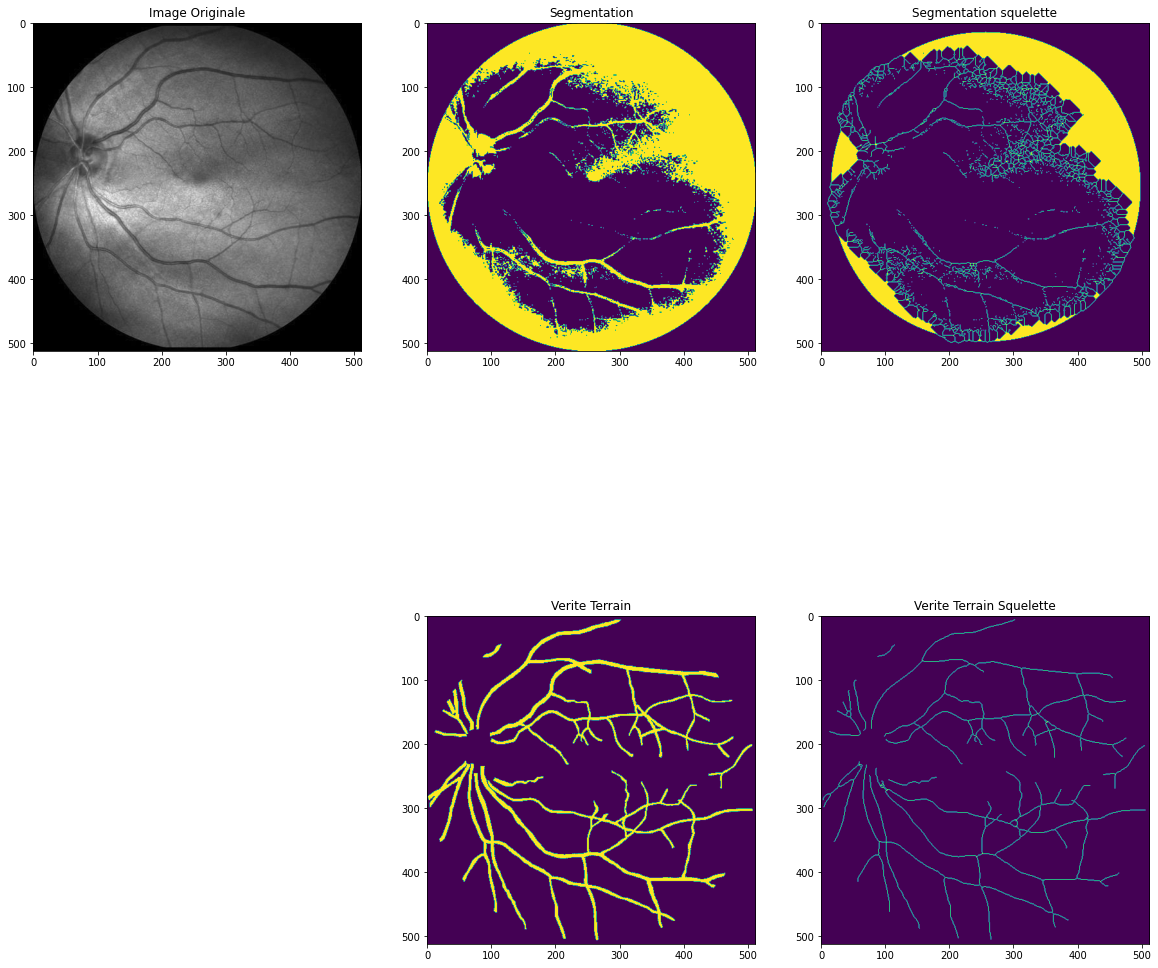

In [144]:

#Ouvrir l'image Verite Terrain en booleen
img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
print('Accuracy =', ACCU,', Recall =', RECALL)

plt.figure(figsize=(20,20))
plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
plt.subplot(232)
plt.imshow(img_out)
plt.title('Segmentation')
plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')
plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')
plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()

# PRETRAITEMENT IMAGE

In [145]:
#img = cv2.equalizeHist(img)

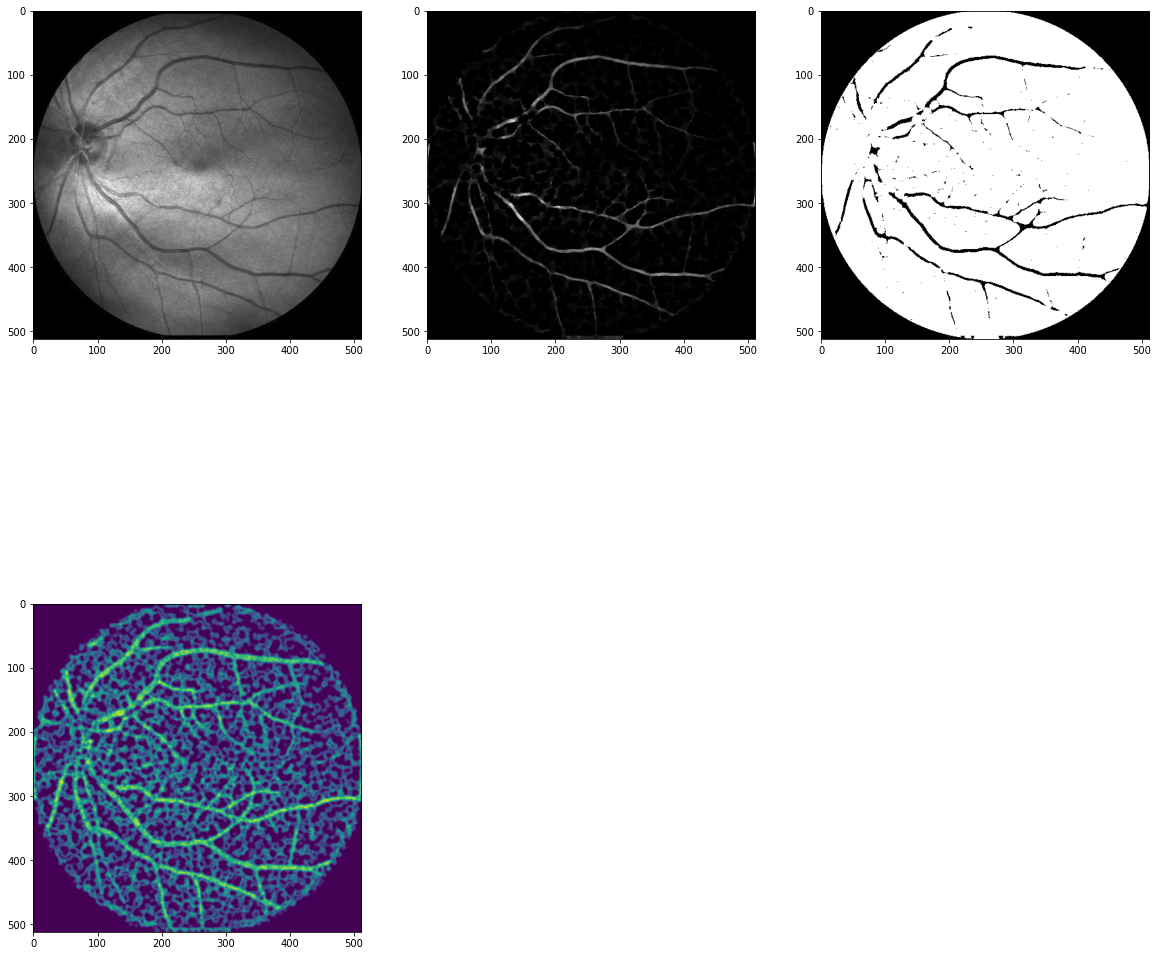

In [162]:
se4 = diamond(5)
def granulometrie(img,se,n) :
    for i in range(n):
        img = opening(closing(img,se),se)
    return img
def granulometrie_inv(img,se,n) :
    for i in range(n):
        img = closing(opening(img,se),se)
    return img

def essai(img,se,n) :
    for i in range(n) :
        img = erosion(dilation(img,se),se)
    return img

def GradInt(img,se) :
    return img - erosion(img,se)
def complementaire(img) :
    return 255 - img
def GradExt(img,se) :
    return dilation(img,se) - img

def GradMorph(img,se) :
    return dilation(img,se) - erosion(img,se)
def LapMorph(img,se) :
    return GradExt(img,se).astype(np.float16) - GradInt(img,se).astype(np.float16)
new_img = essai(img,se4,10)
img_out = my_segmentation(new_img,img_mask,75)
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.imshow(img,cmap='gray')
plt.subplot(232)
new_img = black_tophat(img,se4)

new_img = essai(new_img,diamond(3),1)
new_img = white_tophat(new_img,se4)
new_img = essai(new_img,disk(5),1)
new_img = white_tophat(new_img,disk(7))
plt.imshow(new_img,cmap='gray')
plt.subplot(233)

entro = entropy(new_img,diamond(3))
masked = my_segmentation(complementaire(new_img),img_mask,10)
plt.imshow(masked,cmap='gray')
plt.subplot(234)
plt.imshow(entro)
plt.show()
#regarder area opening
#algorithme de brezenham